In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import classification_report
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, Phrases
pd.options.display.float_format = '{:,.4f}'.format
seed = 42
np.random.seed(seed)

In [3]:
df = pd.read_csv("task-3-dataset.csv") # Считываем данные

In [4]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')
# Функция загрузки стопслов
def downloads_():
    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords

# Функция обработки текта
def foo(review):
    # Обработка текста отзыва. Оставляем только буквы, приводим к нижнему регистру
    review = review.lower()
    review = review.replace('ё','е')
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^а-я]', ' ', review)
    # Отделяем слова
    review = review.split()
    # Избавляемся от стоп-слов(предлоги,союзы, частицы, не несущие семантической нагрузки)
    review = [word for word in review if not word in set(stopwords.words('russian'))]
    # Лемматизируем(для русского языка в явном виде нет, но пока тк)
    # В явном виде лемматизации нет для русского языка,  SNOWBALL STEMMER как вариант
    lemmatized_words = [morph.normal_forms(word)[0] for word in review]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [5]:
# Разделим данные, пока нет тестовых
from sklearn.model_selection import train_test_split
df["разметка"].loc[df["разметка"]=="+"]=1
df["разметка"].loc[df["разметка"]=="-"]=0
df["отзывы"] = df["отзывы"].apply(foo)
#dataset_train, dataset_test, train_data_label, test_data_label = train_test_split(df['отзывы'], df['разметка'], test_size=0.2, random_state=42)

In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer()

In [7]:
downloads_()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fayne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(df['отзывы'])
#transformed test reviews
print('Tfidf_train:',tv_train_reviews.shape)

Tfidf_train: (210, 3884)


In [9]:
# Применим метод главных компонент для того, чтобы сократить вектор TF-IDF
from sklearn.decomposition import PCA
def reduce_dimensionality(X, n_components=16): # число кубит
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)

In [10]:
# Обрежем данные
X = tv_train_reviews.copy()
y = df['разметка']
X_reduced = reduce_dimensionality(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2)

In [11]:
import qiskit
from qiskit_aer import Aer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler, Estimator
#from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.circuit.library import QNNCircuit



In [12]:
# Создадим квантовую схему
n_qubits = 4 # Число кубит
circuit = QuantumCircuit(n_qubits)
# Параметры для схемы
params = [Parameter(f'theta_{i}') for i in range(n_qubits * 2)]
# Кодирование данных
for i in range(n_qubits):
    circuit.ry(params[i], i)
# Параметризированные вращения
for i in range(n_qubits - 1):
    circuit.cx(i, i + 1)
# Добавляем измерения
circuit.measure_all()
# Рисуем схему в текстовом формате
print(circuit.draw(output='text'))

        ┌─────────────┐                ░ ┌─┐         
   q_0: ┤ Ry(theta_0) ├──■─────────────░─┤M├─────────
        ├─────────────┤┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ┤ Ry(theta_1) ├┤ X ├──■────────░──╫─┤M├──────
        ├─────────────┤└───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ┤ Ry(theta_2) ├─────┤ X ├──■───░──╫──╫─┤M├───
        ├─────────────┤     └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ Ry(theta_3) ├──────────┤ X ├─░──╫──╫──╫─┤M├
        └─────────────┘          └───┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════════════╩══╩══╩══╩═
                                          0  1  2  3 


In [13]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

num_inputs = 4
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs,reps=1)

circuit = QuantumCircuit(num_inputs)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

def parity(x):
    return "{:b}".format(x).count("1") % 2

In [65]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler

sampler = Sampler()
sampler_qnn = SamplerQNN(
    circuit=circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    sampler=sampler,
)

C:\Users\fayne\AppData\Local\Temp\ipykernel_24296\3788435028.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\fayne\AppData\Local\Temp\ipykernel_24296\3788435028.py:5: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


In [ ]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss="cross_entropy",
    one_hot=True,
)
classifier.fit(np.asarray(X_train), np.asarray(y_train))

In [75]:
y_pred = classifier.predict(X_test)
y_pred = [int(i) for i in y_pred]
y_true = [int(i) for i in y_test]

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Вывод точности
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Вывод precision, recall и f1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.57
Precision: 0.59
Recall: 0.57
F1 Score: 0.57


# Pennylane

In [114]:
# Обрежем данные
X = tv_train_reviews.copy()
y = df['разметка']
X_reduced = reduce_dimensionality(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2)

In [126]:
from torch.utils.data import DataLoader
import torch
batch_size = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(X_train,  batch_size=batch_size,shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [127]:
import pennylane as qml
num_classes = 2
feature_size = 16
# number of qubits - logarithm of numbers of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 30
margin = 0.15

lr_adam = 0.001
num_epochs = 6
dev = qml.device("default.qubit", wires=num_qubits)

In [128]:
def layer(W, flag=None):
    for i in range(num_qubits):
        qml.RY(W[i], wires=i)
    if (flag == None): # add last layer without entangling gates
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j + 1])

def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)
    qml.Barrier(list(range(num_qubits))) # for drawing
    
    for i, W in enumerate(weights):
        if i < len(weights) - 1:
            layer(W)
        else:
            layer(W, 'last')
        qml.Barrier(list(range(num_qubits)))

    return qml.expval(qml.PauliZ(0)) # observable

In [129]:
# for classifiers
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

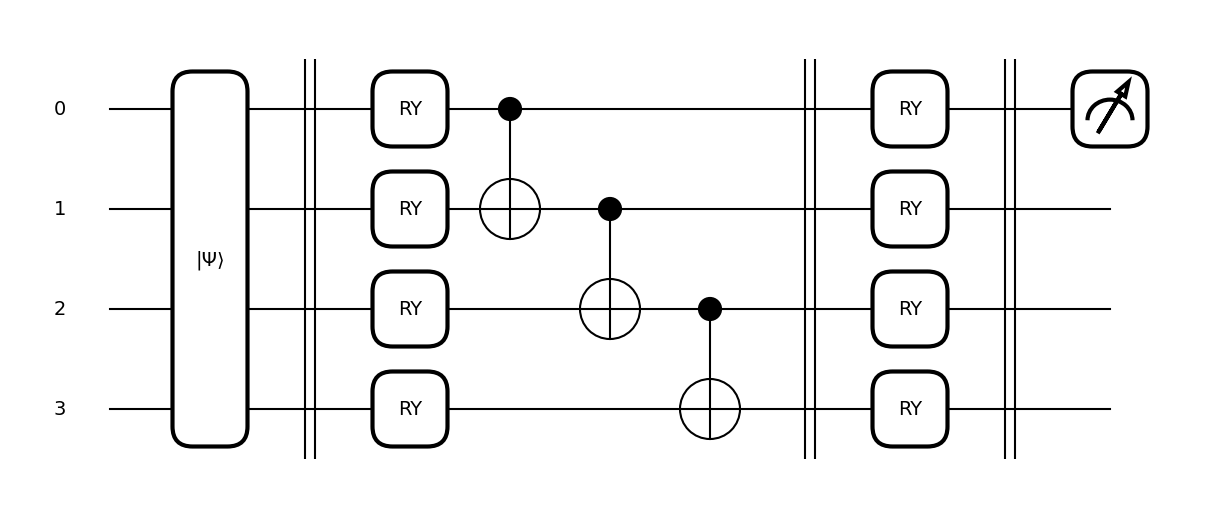

In [130]:
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torch

all_weights = Variable(0.1 * torch.randn(1 + 1, num_qubits), requires_grad=True)
all_bias = Variable(0.1 * torch.ones(1), requires_grad=True)
params = (all_weights, all_bias)

fig, ax = qml.draw_mpl(circuit)(params[0], params[1])
plt.show()

In [131]:
def margin_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        feature_vec = feature_vec.to(device)

        # Let's calculate the score assigned to this sample by the classifier corresponding to the true label
        s_true = variational_classifier(q_circuits[int(true_labels[i])],
                                        (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
                                        feature_vec)
        s_true = s_true.float()

        # Let's get values for the wrong classes
        li = 0
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(q_circuits[j],
                                            (all_params[0][j], all_params[1][j]),
                                             feature_vec)
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).to(device).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

In [132]:
def classify(q_circuits, all_params, feature_vecs):
    predicted_labels = []
    for feature_vec in feature_vecs:
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(q_circuits[c],
                                           (all_params[0][c], all_params[1][c]),
                                           feature_vec)
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels


def accuracy(labels, hard_predictions):
    acc = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            acc += 1
    acc = acc / labels.shape[0]
    return acc

In [133]:
from collections import defaultdict
import matplotlib.pyplot as plt

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [134]:
def to_device_(list_of_tensors, device):
    for tensor in list_of_tensors:
        tensor = tensor.to(device)
    return list_of_tensors

In [ ]:
%%time
from torch.autograd import Variable
import torch.optim as optim

pp = ProgressPlotter(groups=['loss', 'accuracy'])

q_circuits = qnodes

# Random parameters initialization
all_weights = to_device_([Variable(0.1 * torch.randn(num_layers + 1, num_qubits).to(device), requires_grad=True) for i in range(num_classes)], device)
all_bias = to_device_([Variable(0.1 * torch.ones(1).to(device), requires_grad=True) for i in range(num_classes)], device)

optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)

params = (all_weights, all_bias)
print("Num params: ", num_classes * (num_qubits * (num_layers + 1) + 1))

for e in range(num_epochs):
    loss_train = 0
    acc_train = 0
    for i, batch in enumerate(train_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)

        optimizer.zero_grad()

        curr_cost = margin_loss(q_circuits, params, x, labels)
        l = curr_cost.detach().cpu().numpy()[0]
        print(l, file=open(f"logs/loss_{e}_6lays_001lr.txt", "a+"))
        loss_train += l

        pred = classify(q_circuits, params, x)
        a = accuracy(labels, pred)
        print(a, file=open(f"logs/acc_{e}_6lays_001lr.txt", "a+"))
        acc_train += a
        
        curr_cost.backward()
        optimizer.step()

        print(f"Train: Epoch {e}, batch #{i+1}/{len(train_loader)}, loss={l}")

    loss_train /= len(train_loader)
    acc_train /= len(train_loader)

    loss_val = 0
    acc_val = 0
    for i, batch in enumerate(test_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)

        curr_cost = margin_loss(q_circuits, params, x, labels)
        l = curr_cost.detach().cpu().numpy()[0]
        print(l, file=open(f"logs/loss_val_{e}_6lays_001lr.txt", "a+"))
        loss_val += l

        pred = classify(q_circuits, params, x)
        a = accuracy(labels, pred)
        print(a, file=open(f"logs/acc_val_{e}_6lays_001lr.txt", "a+"))
        acc_val += a

        print(f"Validation: Epoch {e}, batch #{i+1}/{len(test_loader)}, accuracy={a}")

    loss_val /= len(test_loader)
    acc_val /= len(test_loader)

    pp.add_scalar('loss', loss_train, 'train')
    pp.add_scalar('loss', loss_val, 'test')

    pp.add_scalar('accuracy', acc_train, 'train')
    pp.add_scalar('accuracy', acc_val, 'test')
    
    pp.display()

Num params:  250


IndexError: too many indices for tensor of dimension 1